# Comparing time series predictions of COVID-19 deaths


![Comparison](comparison.png)

# Task 1: Understand the basics of time series analysis

- What's a time series?
  - It's a table of values, such as temperature or stock price, that are observed at regular times, such as every hour or every day.
  - Here is a simple time series: temperatures in Celcius in The Neighborhood over 10 days.

| Day         | Temperature |
| ----------- | ----------- |
| 11 May 2022 | 23          |
| 12 May 2022 | 21          |
| 13 May 2022 | 24          |
| 14 May 2022 | 19          |
| 15 May 2022 | 18          |
| 16 May 2022 | 20          |
| 17 May 2022 | 21          |
| 18 May 2022 | 22          |
| 19 May 2022 | 20          |
| 20 May 2022 | 21          |

- One would want to know: what's the temperature after 20 May 2022? Predicting the data values (temperature) in the future is called forecasting.
- Workflow for time series analysis:
  - Step 1: Underst the data (Task 2)
  - Step 2: Identify the right model (Tasks 3, 4, 5, 6, 7)
  - Step 3: Use the best model to forecast future values (Task 8)

- To make the best out of this hands-on project, we need to learn a few concepts before the hands-on tasks.

## Common features in time series data


![Trends and seasons](trends_seasons.png)

- These are three common features in every time series data:
    - Seasons: The regular ups and downs in your data, like in the figure above.
    - Trends: When you find that data is general going upward or downword. In the figure above, there is an upward trend.
    - Cycles: Where there are ups and downs in the data that do not seem to repeat regularly.
- We can observe the above three features by plotting the data, and checking it visually.

## Stationarity

- A stationary time series: it's the time series in which the average and variance do not change; so these statistical properties are *independent of time*. 
- Therefore, a time series with trends is not stationary. An example of such data is in the figure above.
- Non-stationary data are not easy to predict, but stationary data are much easier to predict.
- Therefore, we need to make our time series data stationary before we feed them into statistical models.
- You will learn how to turn non-stationary data into stationary data by using differencing.


## The dataset

We obtain the dataset from the Github page of John Hopkins Center for System Science and Engineering:

[https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)


# Task 2: Explore and prepare the data

In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')


Matplotlib created a temporary config/cache directory at /home/rhyme/.config/matplotlib because the default path (/tmp/matplotlib-7oif89is) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Importing plotly failed. Interactive plots will not work.


First, get the data for the daily deaths in all countries in the report.

Let's have a look at how the data looks like, by using the head() method from the DataFrame class:

In [2]:
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/22,5/7/22,5/8/22,5/9/22,5/10/22,5/11/22,5/12/22,5/13/22,5/14/22,5/15/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7684,7684,7684,7685,7685,7686,7686,7686,7687,7690
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3496,3496,3497,3497,3497,3497,3497,3497,3497,3497
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6875,6875,6875,6875,6875,6875,6875,6875,6875,6875
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


And here are the columns:

In [3]:
deaths_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/6/22', '5/7/22', '5/8/22', '5/9/22', '5/10/22', '5/11/22', '5/12/22',
       '5/13/22', '5/14/22', '5/15/22'],
      dtype='object', length=849)

So the columns are arranged as follows: <br>
<ul>
    <li>
        feature columns such as Province, Country etc. </li>
    <li>date columns, starting from the first reporting date, 1/22/2020, until two days ago (with respect to the time of recording this course</li>
   </ul>
 
The date columns start from 1/22/20, so let's take the data in these columns separately.
    
    

In [4]:
d = deaths_df.loc[:, '1/22/20': ] ##Now we got deaths along the columns, but we want deaths along the rows

Transpose the data frame

In [5]:
d = d.transpose()

Then sum row-wise

In [6]:
d = d.sum(axis=1)

We only need the numeric values here, so we convert `d` to a list

In [7]:
d.head()
d = d.to_list()## converting the dataframe to a list of values

Create a new data frame with two columns. This will be our dataset:

In [8]:
dataset = pd.DataFrame(columns=['ds', 'y'])

Get the dates from the columns in `deaths_df` data frame, starting from the fifth column. They will be obtained in string format.

In [9]:
dates = list(deaths_df.columns[4:])

Convert the string dates into the datetime format using the `to_datetime()` method, so that we can perform datetime operations on them

In [10]:
dates = list(pd.to_datetime(dates)) ## to_datetime() is often used in timeseries analysis tasks to convert a column of a dataframe or a series from a string format to a datetime format, which is a special datatype for handling dates and times

Now, assign the dates and deaths data to the columns in the new dataframe:

In [11]:
dataset['ds'] = dates
dataset['y'] = d

We will need to have only 1 data column, y, with the index being `ds`:

In [12]:
dataset= dataset.set_index('ds')

Let's plot the daily number of deaths


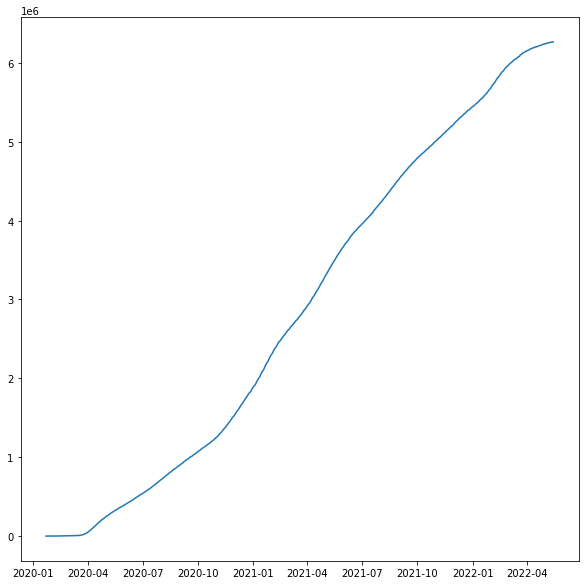

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(dataset)
plt.savefig('cummulative_daily_deaths', bbox_inches='tight', transparent=False)

The increase has been tremendous, but it seems to start to plateau. Maybe too early to know? I'd leave that discussion to the scientists in charge.<br>

This time series is obvious non-stationary, and we cannot observe any seasonal behavior here. Let's perform seasonal decomposition of the data by using the `seasonal_decompose()` function from `statsmodel`:

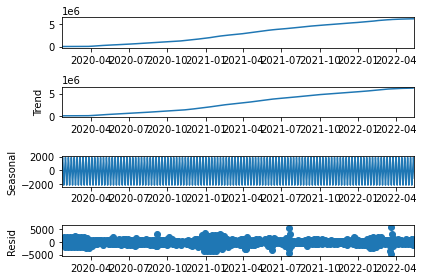

In [14]:
seas_d=sm.tsa.seasonal_decompose(dataset,model='add');
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()  ##after looking at the graphs we can say that even thought the graph seem to increase monotonically but there is a hidden seasonality in the data

The data is both seasonal and trending upwords. We need the data to be stationary so that we can apply our models to it.

Let's make our dataset stationary by taking the difference between consecutive elements, which in our case will be the daily change in the number of deaths. To do this, we will use the `diff()` method from the `dataset` DataFrame object.

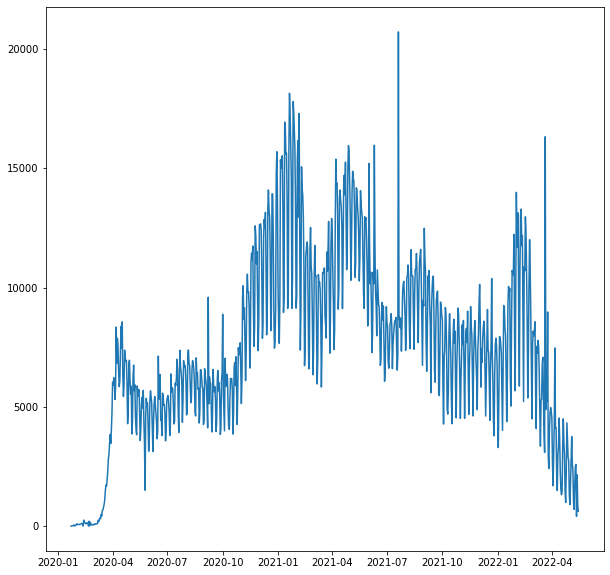

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(dataset.diff()) ##now the seasonality will be exposed, and we can see that this data is far from being stationary
plt.savefig('daily_deaths_diff', bbox_inches='tight', transparent=False)

Let's zoom in:

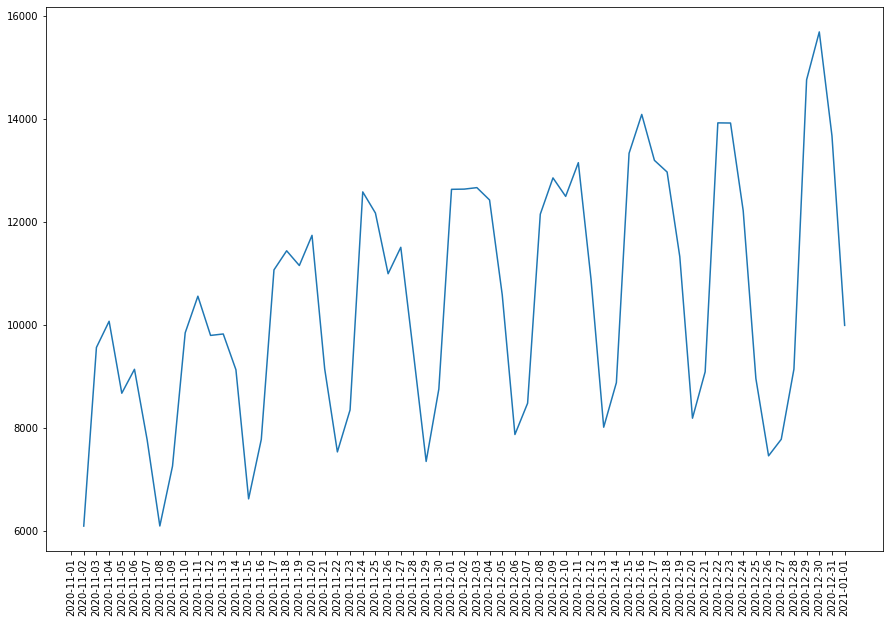

In [16]:
plt.figure(figsize=(15, 10))
sample = dataset.loc['2020-11-01':'2021-01-01']
plt.plot(sample.diff())
plt.xticks(sample.index,rotation=90)
plt.savefig('daily_deaths_diff_sample', bbox_inches='tight', transparent=True)

Let's count the period length - it's 7 days! The seasonality of deaths is therefore weekly. But there is still an upword trend in the data.

Therefore, it is not yet stationary, so let's take the `diff()` one more time. Doing that is what is known as *second-order differencing*.

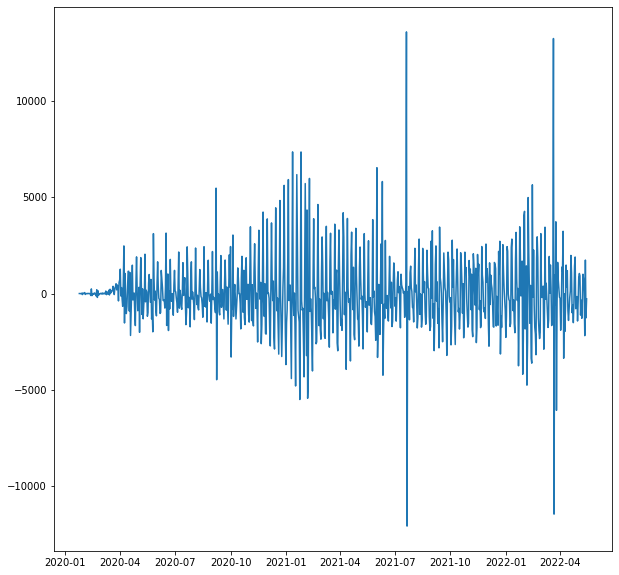

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(dataset.diff().diff())
plt.savefig('daily_deaths_2nd-order_diff', bbox_inches='tight', transparent=False)

This is clearly stationary enough, and we will be using this for our subsequent analysis.

The second-order differencing is essentially the difference of the difference, or the change in the change.

In [18]:
dataset_diff = dataset.diff().diff()

We need to remove the first two data point here, which will be two `None` values after applying `diff()` twice:

In [19]:
##skipping the first 2 records means skipping the 22nd and 23rd of jan
dataset_diff = dataset_diff.loc['2020-01-24':]

The last step in this task is to split our dataset into a training and a test set. 
- When we train ML models, we typically use 20% of the dataset as a test set.
- In time series analysis, the the size of the test set should be close to the extent of the future data.
- In this exercise, we are only going to predict 1 month into the future. Therefore, we will use all the data before 15 April 2022 as training set.



2022-04-15


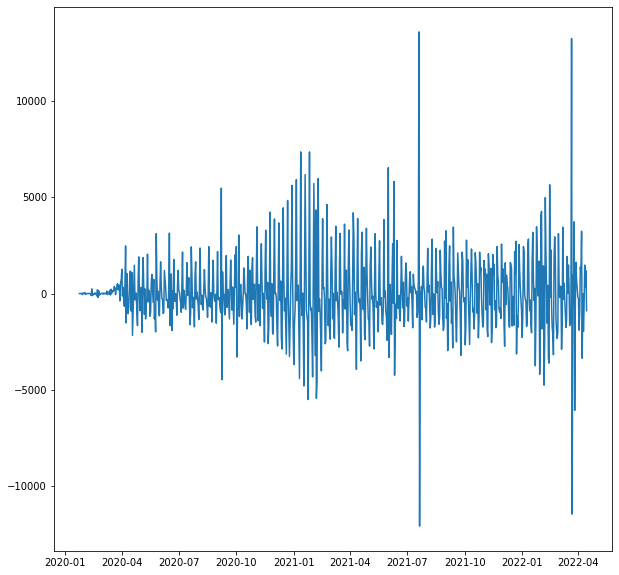

In [20]:
##splitting the data into train set and test set
cutoff_date = '2022-04-15'

print(cutoff_date)

train = dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)]
test = dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)]

plt.figure(figsize=(10, 10))
plt.plot(train)
plt.savefig('training_set', bbox_inches='tight', transparent=False)

# Task 3: Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

SARIMAX is one of the time series models in the python statistics library `statsmodels`.

SARIMAX uses two sets of parameters:
- The `order`: a tuple of values `p`, `q` and `d`. They control the number of parameters in the model. Here, let's use p=2, q=1 and d=3.
- The `seasonal_order`: a tuple of values `P`, `D`, `Q` and `s`. They control the seasonal component of the model, and `s` is the periodicity of the dates. So for example, weekly periodicity can be set with `s=7`.

In [21]:
model = SARIMAX(train, order=(2, 1, 3), seasonal_order=(0,0,0,7))

Next, we call the fit method to optimize the model.

In [22]:
results = model.fit(disp=True)

Now let's make predictions using the model, and compare those against the values in the test set.

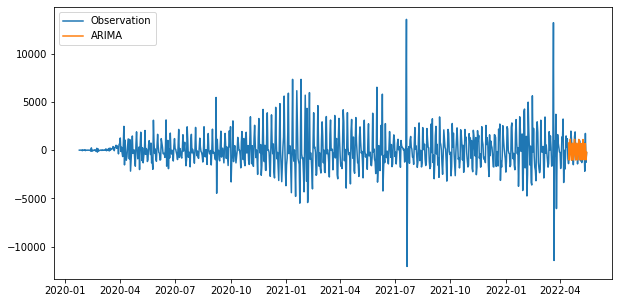

In [23]:
sarimax_prediction = results.predict(
    start=cutoff_date, end='2022-05-15', dynamic=False)
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset_diff, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX_prediction', bbox_inches='tight', transparent=False)
##seasonality is captured in the dataset that matched with th original dataset

Since that we are interested in comparing between the different time series analysis approaches, we are going to use one of the validation measures: mean absolute error.

In [24]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE =  973.1054630636036


However, in a typical machine learning workflow, we should find the best values of p, q and r that will minimize the error. We can use the auto_arima function in the pmdarima module to do that. This will find the optimal parameter combintation and return the best model.


In [25]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      m=7,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=14177.690, Time=3.37 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14608.306, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14132.519, Time=1.44 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14246.854, Time=1.87 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14606.310, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=14609.181, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=14012.943, Time=6.04 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13931.644, Time=6.85 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13911.738, Time=2.99 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=14380.746, Time=0.94 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=13932.910, Time=6.89 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=14270.143, Time=2.79 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=14032.703, Time=2.08 sec
 ARIMA(2,0,0)(1,0,1)[7] i

Note that this gives us the best mode here: "Best model:  SARIMAX(3,0,2)(2,0,1)[7]". Now let's fit it.

SARIMAX auto MAE =  1124.8016676896048


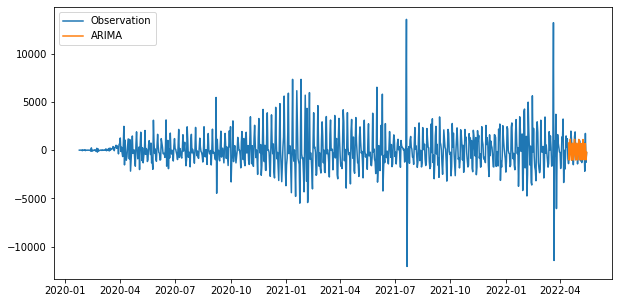

In [26]:
sarimax_prediction_atutomated = model.predict(n_periods=test.shape[0])
sarimax_prediction_atutomated = pd.DataFrame({'ds':test.index,'y':sarimax_prediction_atutomated})
sarimax_prediction_atutomated.set_index('ds',inplace=True)
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset_diff, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX_prediction_automated', bbox_inches='tight', transparent=False)
print('SARIMAX auto MAE = ', mean_absolute_error(sarimax_prediction_atutomated, test))

Woops: the model that is selected by the `auto_arima()` method is doing worse in terms of MAE! 

This is related to a long discussion on: *which accuracy measure to use when we compare time series models?*

We will not have time here to delve into it, so we will just choose the model that has the lowest MAE.

Let's run the standard diagnostics:

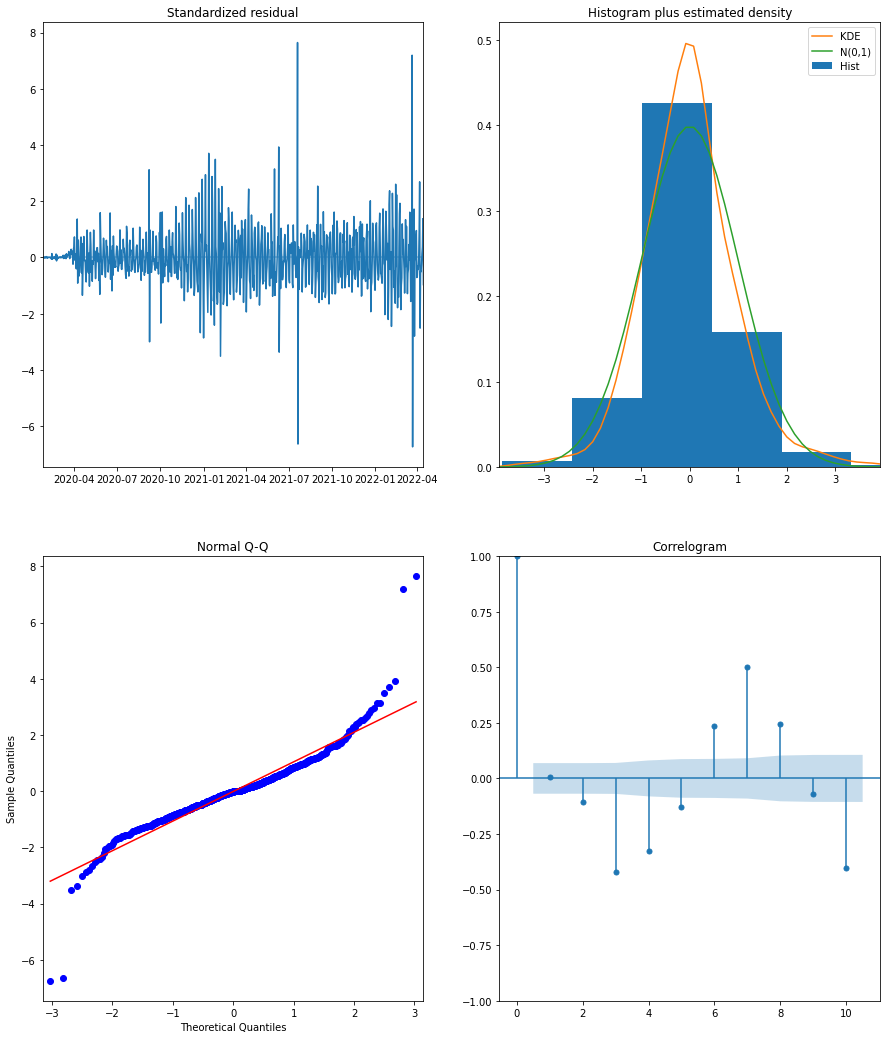

In [27]:
results.plot_diagnostics(figsize=(15, 18))
plt.show()

- The diagnostic plots enable us to analyse the accuracy of our model, and whether there is any (residual) information in the data that should be used to improve the model.
- The package provides four diagnostic plots. Below I only give a very brief description of these plots.
  - Standardized residuals over time plot: Calculates the residue, or the difference between observed and predicted values, as a function of time.
  - Histogram: It's the count of values against the computed residual. Note: that residual in the x-axis was the one in the y-axis in the plot above.
  - Normal Q-Q: Typically, model errors should be normally distributed. This plot checks if this is the case; if the points are nearly linear, then the errors are normally distributed. Which is the case in our plot.
  - Correlogram: Checks the autocorrelation in the data, to ensure that the data is random. 
- *Randomness of data* is a necessary condition for the *validity* of the model, and it is checked by the correlogram.
- In the correlogram, the *autocorrelation* is plotted against *time lags*. If the values are close to zero, then this is an indication of the randomness of the data, as is the case in our plot above.

# Task 4: Forcasting using Facebook's Prophet model

This is the open source time series library released by Facebook. It is also widely used by Facebook in their own time series analysis tasks. Facebook prophet does not require that you specify or search for hyperparameters. The model can act as a black box that does all the required computations on its own. And it works with the same object-fit-predict API.

Prophet expects the data frame to have 2 columns, unlike SARIMAX.

In [28]:
train['ds'] = train.index.values

Then we create a new Prophet object and call the `fit()` method

In [29]:
m =Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- Now let's use the model to generate the predictions for the test set.
- First we create the `future` data frame using `make_future_dataframe()`, then we call the `predict()` function.
- In `make_future_dataframe()`, we pass the `periods` parameter, which is the number of days we want for prediction.

In [30]:
future = m.make_future_dataframe(periods = test.shape[0])
prophet_prediction = m.predict(future)

Now let us calculate the mean absolute error for our predictions.

In [31]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= cutoff_date]
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))

Prophet MAE =  703.8375294363916


Next, let's visualize the predictions.

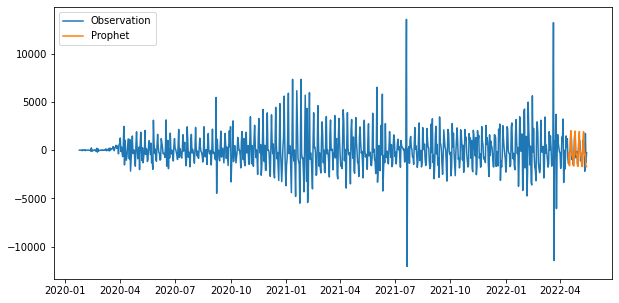

In [32]:
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset_diff, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1, l2])
plt.savefig('prophet predictions',
            bbox_inches='tight', transparent=False)

# Task 5: Preparing the dataset for XGBOOST and NN

Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [33]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    ##to prevent data duplication we have to also add year
    X['year'] = t.index.year
    y = t.y
    return X, y ##X is the featurization or representation of the date and y is the y value


featurize(dataset_diff)[0].head() ##featurize representation of the first 5 records of our dataset

,day,month,quarter,dayofweek,dayofyear,weekofyear,year
0,24,1,1,4,24,4,2020
1,25,1,1,5,25,4,2020
2,26,1,1,6,26,4,2020
3,27,1,1,0,27,5,2020
4,28,1,1,1,28,5,2020


# Task 6: Create training and test datasets by splitting the dataset, and perform data normalization.

In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [34]:
##create train and test dataset based on the featurize function
X_train, y_train = featurize(
dataset_diff.loc[dataset_diff.index < pd.to_datetime(cutoff_date)])
X_test, y_test = featurize(
dataset_diff.loc[dataset_diff.index >= pd.to_datetime(cutoff_date)])

Now let's discuss data normalization. We perform data normalization so as to make the range of values of the features, or the columns in the X_train table, as close as possible. For example, we have the features dayofweek and dayofyear. The range of values of dayofweek is from 1 to 7, whereas dayofyear is from 1 to 365. Having such large differences in the ranges of values will either slow down the training of the machine learning model or make it quite difficult. We solve this problem by applying normalization. There are several ways we can normalize the data with. Here I will choose the StandardScaler, which applies the following equation on each of the columns.

z = (x - u) / s

Here x is the column before scaling, u is thee mean and s is the standard deviation. So basically, we subtract the mean of each column from itself, then divide by the standard deviation of that column. To apply StandardScaler, we first fit the scaler object to the dataset:


In [35]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Apply the scaling to both the training and test sets, as follows.

In [36]:
scaled_train = scaler.transform(X_train) ##based on the fit which is only on the train dataset we are transforming now the train and test dataset
scaled_test = scaler.transform(X_test) ## we are scaling the test set based on training dataset, we are not creating a scaler and fit into all the data at first

# Task 7: Train the XGBOOST and NN models

First, create the XGBRegressor object which will represent the XGBOOST regression model.

In [37]:
XGBOOST_model = XGBRegressor(n_estimators = 7)

Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [38]:
XGBOOST_model.fit(scaled_train, y_train,
                 eval_set = [(scaled_train, y_train), (scaled_test, y_test)],
                 verbose = True) ##verbose is for seeing the steps of fitting
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[0]	validation_0-rmse:1614.15515	validation_1-rmse:843.27832
[1]	validation_0-rmse:1384.05981	validation_1-rmse:788.98096
[2]	validation_0-rmse:1246.29346	validation_1-rmse:792.73737
[3]	validation_0-rmse:1125.48010	validation_1-rmse:861.60211
[4]	validation_0-rmse:1040.73914	validation_1-rmse:866.06799
[5]	validation_0-rmse:985.25940	validation_1-rmse:892.15576
[6]	validation_0-rmse:927.66931	validation_1-rmse:920.67401


Let us calculate the mean absolute error for the training.

In [39]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE =  755.3305974160471


Creation and training of the feedforward neural network model.

In [40]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=210, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/210
26/26 [==============================] - 0s 14ms/step - loss: 1293.7305 - val_loss: 936.1295
Epoch 2/210
26/26 [==============================] - 0s 4ms/step - loss: 1293.3634 - val_loss: 935.6122
Epoch 3/210
26/26 [==============================] - 0s 4ms/step - loss: 1292.9462 - val_loss: 934.9555
Epoch 4/210
26/26 [==============================] - 0s 4ms/step - loss: 1292.4298 - val_loss: 934.1453
Epoch 5/210
26/26 [==============================] - 0s 3ms/step - loss: 1291.7106 - val_loss: 932.9905
Epoch 6/210
26/26 [==============================] - 0s 3ms/step - loss: 1290.7782 - val_loss: 931.3870
Epoch 7/210
26/26 [==============================] - 0s 5ms/step - loss: 1289.5216 - val_loss: 929.3315
Epoch 8/210
26/26 [==============================] - 0s 2ms/step - loss: 1287.8854 - val_loss: 926.5887
Epoch 9/210
26/26 [==============================] - 0s 4ms/step - loss: 1285.7117 - val_loss: 922.9868
Epoch 10/210
26/26 [==============================] - 0s 3ms/st

Let's compare the MAE values.

In [41]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))
print('NN MAE = ', mean_absolute_error(NN_prediction, test))

XGBOOST MAE =  755.3305974160471
Prophet MAE =  703.8375294363916
SARIMAX MAE =  973.1054630636036
NN MAE =  749.9629319713962


The peformance of SARIMAX is the lowest, while that of XGBOOST is the highest. <br>
Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

<Figure size 1440x1440 with 0 Axes>

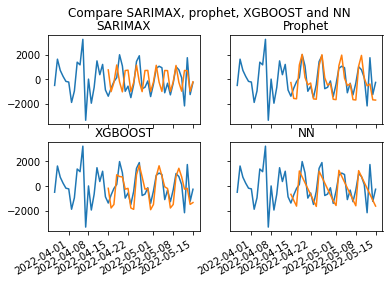

In [42]:
##printing out the predictions of the models
XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset_diff.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50)) ##only focusing on the last 50 days
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset_diff.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset_diff.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset_diff.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('comparison',
            bbox_inches='tight', transparent=False)

# Task 8: Forecast the future

- We have established the XGBOOST model is the most accurate, and therefore we can use it to forcast the future COVID19 deaths i.e. beyond 15th May 2022.
- For the sake of exercise, we will apply all four models for the forecast.
- We will ask the four models to forecast 1 month into the future: from 16th May 2022 to 16th June 2022.
- Prediction with SARIMAX and fbprophet is straightforward:

In [49]:
sarimax_future_prediction = results.predict(start = '2020-01-24', end =  '2022-06-15')
## for prophet forecasting
future = m.make_future_dataframe(periods=test.shape[0] + 31)
prophet_future_prediction = m.predict(future)
prophet_future_prediction = prophet_future_prediction.set_index('ds')

- For XGBOOST and NN, we need to generate the `X` dataset as we did before. We need to create a new function like `featurize()`, which takes a DataFrame of dates only.

In [50]:
def featurize_dates(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    X['year'] = t.index.year
    return X


Let's apply it on the `future` DataFrame we got from fbprophet to generate forecasts using the trained XGBOOST model:

In [51]:
future = future.set_index('ds')
X_future = featurize_dates(future)
scaled_future = scaler.transform(X_future)
XGBOOST_future = XGBOOST_model.predict(scaled_future)

We do the same for the NN:

In [53]:
NN_future = NN_model.predict(scaled_future)

Finally, let's plot the entire time series including training, test and future predictions:

<Figure size 1440x1440 with 0 Axes>

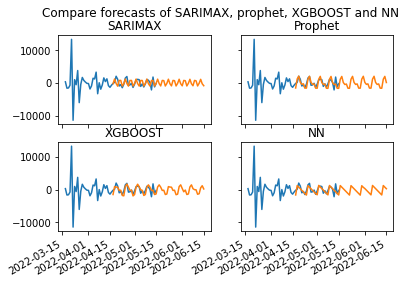

In [54]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_future.tolist()})
XGBOOST_df.index = future.index

future_prediction_count = 31 + test.shape[0]

NN_df = pd.DataFrame(NN_future)
NN_df.index = future.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare forecasts of SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset_diff.tail(60))
axs[0, 0].plot(sarimax_future_prediction.tail(60))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset_diff.tail(60))
axs[0, 1].plot(prophet_future_prediction['yhat'].tail(60))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset_diff.tail(60))
axs[1, 0].plot(XGBOOST_df.tail(60))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset_diff.tail(60))
axs[1, 1].plot(NN_df.tail(60))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('comparison_forecasts',
            bbox_inches='tight', transparent=False)
##original dataset ends on 15th of may and there continues till 15th of june

That's all, I hope you found this tutorial useful!